<font size="5">emcee fit - ASTR 403 - Project/Exam 1</font> <br>  <font size="4"> using <code>astropy.cosmology</code> functions for <code>distance_modulus</code> equation</font>
<br>
<br>
<b> Author:</b> Payton Clem

<hr>

<font size="3"><code>astropy.cosmology</code> is a subpackage to <code>astropy</code> that "contains classes for representing cosmologies and utility functions for calculating commonly used quantities that depend on a cosmological model". For this specific use, the <code>FlatLambdaCDM</code> and <code>LambdaCDM</code> functions will be used to find the distance modulus as well as be used as the model function for out fit. More information (and credit for the quote) can be found by viewing <a href="https://docs.astropy.org/en/stable/cosmology/index.html">readthedocs.astropy</a></font>

In [46]:
from helper_functions import * # importing helper functions python file
import matplotlib.pyplot as plt
from scipy import optimize
from emcee import *
from astropy.cosmology import FlatLambdaCDM, LambdaCDM # the distance_modulus equation that will be used

In [47]:
# defining our chi squared equation to calculate for each fit method used

def chi_squared(modle, measured, error, args):
    top = (measured - modle(*args))**2
    bot = error**2
    return (np.sum(top/bot))

In [48]:
# Getting and sorting the data
data = get_data('data.txt')
zcmb = data[0]  # redshift
mb = data[1]  # observed B-band magnitude
dmb = data[2]  # error of the observed B-band magnitude

y = [] # creating empty array for distance modulus for original data (calling it y)
Mb = -19.3 # the absolute magnitude for a 1a Super Nova
for i in range(len(mb)):
    y.append(get_distance_modulus(mb[i], Mb))

# Defining initial values we will be comparing
H0=70
OM=0.3

x = np.array(zcmb) # turning zcmb into an array and defining it as x
yerr = np.array(dmb)# turning y error into an array and defining it as yerr

# Finding the distance modulus using the FlatLambdaCDM function from Astropy
cosmo = FlatLambdaCDM(H0, OM) # CDM model 
LCDM = cosmo.distmod(zcmb).value # findes distance modulus based off of out CDM model

# The redshift range we will be plotting
x0 = np.linspace(0.01, 2.27, 500)

<font size="4">Comparing the <b>original data</b> to the <b>LCDM Fit</b></font>
<br>
<font size="2"> This is just done to verify that this function is the correct one and matches our model </font>

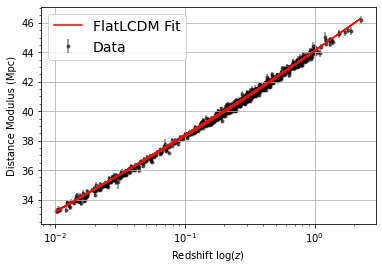

In [50]:
plt.errorbar(zcmb, y, xerr=None, yerr=dmb, fmt='.', color='black', alpha=0.5, label='Data', zorder=1)
plt.plot(x, LCDM, linestyle='-', color='r', label='FlatLCDM Fit', zorder = 2)


plt.grid()
plt.legend(fontsize=14)
plt.xlabel('Redshift $\log(z)$')
plt.ylabel('Distance Modulus (Mpc)')
plt.minorticks_on()
plt.xscale('log')
plt.savefig('LCDM fit.png')
plt.show()

<font size="3"> With this understanding of how the astropy function works, we can write a function (<code>distance_modulus_LCDM</code>) that takes $z, H_0,$ and $\Omega_M$ as the arguments while using the astropy function.</font>

In [51]:
# defining a distance modulus equation using astropy

def distance_modulus_LCDM(x, H0, Om):
    '''
    x: Redshift array
    H0: Hubble Constant, must be in km/sec/MPC
    Om: Omega Matter, must scale from 0-1
    ---------------------------------------------------------
    returns: An array that includes our distance modulus value, 
             will be the same length as 'x' (our redshift).
    '''
    from astropy.cosmology import LambdaCDM, FlatLambdaCDM
    
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om)
 
    # finding distance modulus
    dist_mod = cosmo.distmod(x).value
    
    return(dist_mod)

<font size="5"> From this point on, the emcee tutorial (<a href="https://emcee.readthedocs.io/en/stable/tutorials/line/">emcee.readthedocs.io</a>) will be followed </font>

<b><font size="4"> Least Squares (Curve Fit) Method </font></b>

Estimates:
H0 = 71.668 ± 0.239
Om = 0.283 ± 0.012
Ol = 0.717 ± 0.012

Chi-Squared value for Least-Squares estimate is:
X^2: 1036.8635


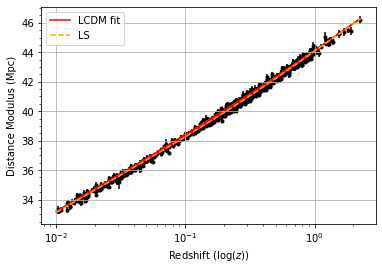

In [61]:
# Least squares fit

pfit, perr = optimize.curve_fit(distance_modulus_LCDM, xdata=x, ydata=y, bounds=([70, 0], [80, 1])) 
err = np.sqrt(np.diag(perr)) # finds the error after doing the fit

# printing output
print("Estimates:")
print("H0 = {0:.3f} ± {1:.3f}".format(pfit[0], err[0]))
print("Om = {0:.3f} ± {1:.3f}".format(pfit[1], err[1]))
print("Ol = {0:.3f} ± {1:.3f}".format(1 - pfit[1], err[1]))

# finding out chi-squared value
LS_chi = chi_squared(distance_modulus_LCDM, y, yerr, [zcmb, pfit[0], pfit[1]])
print('\nChi-Squared value for Least-Squares estimate is:')
print('X^2:',round(LS_chi,4))

# graphing
plt.errorbar(x=zcmb, y=LCDM,fmt='-',c='r', label = 'LCDM fit', zorder=1) # LCDM fit
plt.errorbar(x0, distance_modulus_LCDM(x0, pfit[0], pfit[1]), c = "orange", linestyle = '--', label="LS", zorder=2) # Least Squares Fit
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, zorder=0) # Originial Data

plt.legend(fontsize=10)
plt.minorticks_on()
plt.grid()
plt.xscale('log')
plt.ylabel('Distance Modulus (Mpc)')
plt.xlabel('Redshift ($\log(z)$)')
plt.savefig('least_squares_fit.png');

<font size="3"> The main change from the <code>emcee.readthedocs.io</code> tutorial is that we must change out <code>model</code> in the <code>log_liklihood</code> function and change the bounds in the <code>log_prior</code> function. </font>

In [53]:
def log_likelihood(theta, x, y, yerr):
    H0, OM = theta
    OL = 1 - OM
    model =  distance_modulus_LCDM(x, H0, OM)
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

# including our bounds
def log_prior(theta):
    H0, OM = theta
    if 60.0 < H0 < 80.0 and 0.0 < OM < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

<b><font size="4"> Maximum Liklihood Method </font></b>

Maximum likelihood estimates:
H0 = 71.800
Om = 0.285
Ol = 0.715

Chi-Squared value for Maximum likelihood estimate is:
X^2: 1035.6792


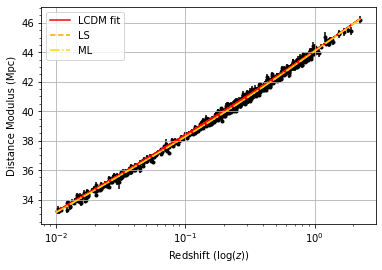

In [62]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([H0, Om]) + 0.01 * np.random.randn(2)
soln = minimize(nll, initial, args=(x, y, yerr), bounds = ([60,80],[0,1]))
H0_ml, Om_ml  = soln.x

# printing out our estimates
print("Maximum likelihood estimates:")
print("H0 = {0:.3f}".format(H0_ml))
print("Om = {0:.3f}".format(Om_ml))
print("Ol = {0:.3f}".format(1-Om_ml))

# finding out our chi-squared values
ML_chi = chi_squared(distance_modulus_LCDM, y, yerr, [zcmb, H0_ml, Om_ml])
print('\nChi-Squared value for Maximum likelihood estimate is:')
print('X^2:',round(ML_chi,4))

# plotting
plt.errorbar(x=zcmb, y=LCDM,fmt='-',c='r', label = 'LCDM fit', zorder=1) #LLCDM fit
plt.errorbar(x0, distance_modulus_LCDM(x0, pfit[0], pfit[1]), c = "orange", linestyle = '--', label="LS", zorder=2) #Least Squares fir
plt.errorbar(x0, distance_modulus_LCDM(x0, H0_ml, Om_ml), c =  "gold", linestyle = '-.', label="ML",zorder =3) # Maximum Liklihood Fit
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, zorder=0) # Orignial Data

plt.legend(fontsize=10)
plt.minorticks_on()
plt.grid()
plt.xscale('log')
plt.ylabel('Distance Modulus (Mpc)')
plt.xlabel('Redshift ($\log(z)$)')

plt.savefig('maximum_liklihood_fit.png');

<b><font size="4"> emcee Method </font></b>

In [13]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 2)

nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [10:16<00:00,  8.57it/s]


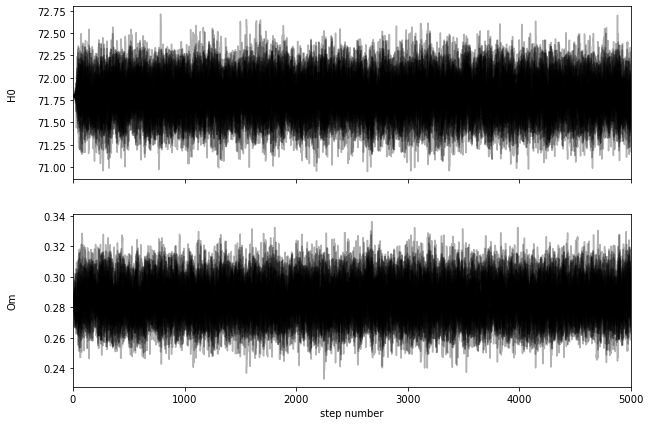

In [55]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["H0", "Om"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

plt.savefig('walkers_distribution.png')

In [56]:
tau = sampler.get_autocorr_time()
print(tau)

[33.80953778 33.40961818]


In [57]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 2)


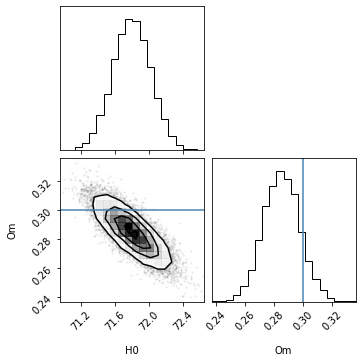

In [58]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[H0, OM]
)

plt.savefig('corner.png')

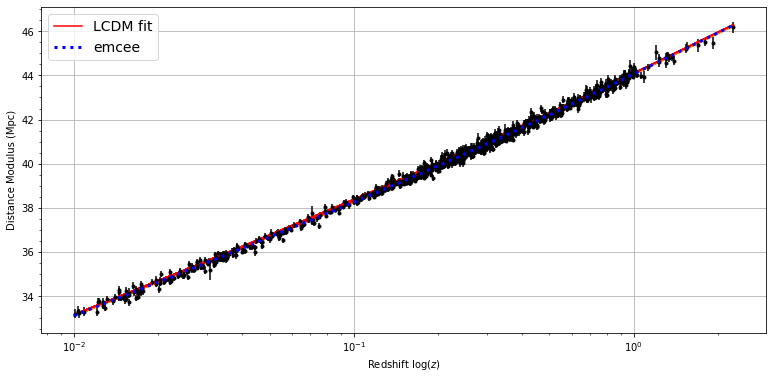

In [68]:
# plotting out emcee fit against the LCDM fit and orginal data

ints = np.random.randint(len(flat_samples), size=100)

# choosing 100 random samples of our fit and plotting them 
plt.figure(figsize=[13,6])

for i in ints:
    sample = flat_samples[i]
    plt.plot(x0, distance_modulus_LCDM(x0, sample[0], sample[1]), "C1", alpha=0.1)

# Finding the 50th percentile of our fits and using that for our emcee values
H0_emcee = np.percentile(flat_samples[:, 0], [50])[0]
Om_emcee = np.percentile(flat_samples[:, 1], [50])
Ol_emcee = 1- Om_emcee

# plotting our initial model and our emcee model
plt.errorbar(x=zcmb, y=LCDM,fmt='-',c='r', label = 'LCDM fit')
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.errorbar(x0, distance_modulus_LCDM(x0, H0_emcee, Om_emcee), lw=3, label="emcee", c = 'blue', 
             linestyle= ':')

plt.legend(fontsize=14)
plt.minorticks_on()
plt.grid()
plt.xscale('log')
plt.ylabel('Distance Modulus (Mpc)')
plt.xlabel('Redshift $\log(z)$')
plt.savefig('lcdm_emcee_fit.png')

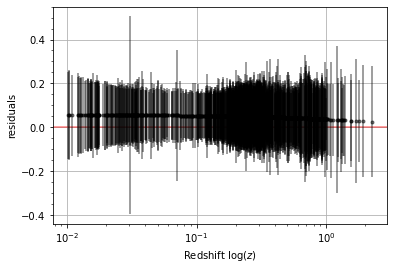

In [70]:
# plotting the residuals when compared to the original data

# finding the residuals
r = distance_modulus_LCDM(x, H0, Om) - distance_modulus_LCDM(x, H0_emcee, Om_emcee)

plt.axhline(0, c = 'r', alpha = 0.5)
plt.errorbar(x = x, y = r, yerr= dmb, fmt = '.', c = 'black', alpha=0.5)

plt.minorticks_on()
plt.grid()
plt.xscale('log')
plt.xlabel('Redshift $\log(z)$')
plt.ylabel('residuals')
plt.savefig('lcdm_resid.png')
plt.show()


In [72]:
from IPython.display import display, Math

# Printing out H0 and Omega_M
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

# Printing out Omega_Lambda
mcmc = np.percentile(flat_samples[:, 1], [16, 50, 84])
q = np.diff(mcmc)
txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
txt = txt.format(1-mcmc[1], q[0], q[1], 'Ol')
display(Math(txt))


# finding our chi-squared value
H0_emcee = np.percentile(flat_samples[:, 0], [50])
Om_emcee = np.percentile(flat_samples[:, 1], [50])

emcee_chi = chi_squared(distance_modulus_LCDM, y, yerr, [zcmb, H0_emcee[0], Om_emcee])
print('\nChi-Squared value for our emcee fit is:')
print('X^2:',round(emcee_chi,4))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


Chi-Squared value for our emcee fit is:
X^2: 1035.6825
